In [1]:
import json
import pandas as pd


with open('/bigtemp/ahs5ce/CS6501_Projects/Project2/data/raw/Timeline.json', 'r') as f:
    data = json.load(f)
print("Top level keys:", data.keys())


Top level keys: dict_keys(['semanticSegments', 'rawSignals', 'userLocationProfile'])


In [2]:
location_records = data.get('semanticSegments', [])

print(f"Number of location records found: {len(location_records)}")

if location_records:
    print("\nExample record:")
    print(location_records[0])


Number of location records found: 758

Example record:
{'startTime': '2025-01-27T09:00:00.000-05:00', 'endTime': '2025-01-27T11:00:00.000-05:00', 'timelinePath': [{'point': '37.9093471°, -78.3332658°', 'time': '2025-01-27T09:51:00.000-05:00'}, {'point': '37.9093471°, -78.3332658°', 'time': '2025-01-27T10:01:00.000-05:00'}]}


In [3]:
records = []

for item in location_records:
    start_time = item.get('startTime')
    end_time = item.get('endTime')
    path = item.get('timelinePath', [])

    for point_entry in path:
        point = point_entry.get('point')
        time = point_entry.get('time')

        if point and time:
            lat_str, lon_str = point.replace('°', '').split(', ')
            latitude = float(lat_str)
            longitude = float(lon_str)

            records.append({
                'start_time': pd.to_datetime(time),
                'latitude': latitude,
                'longitude': longitude
            })

df = pd.DataFrame(records)
print(df.head())


                  start_time   latitude  longitude
0  2025-01-27 09:51:00-05:00  37.909347 -78.333266
1  2025-01-27 10:01:00-05:00  37.909347 -78.333266
2  2025-01-27 12:11:00-05:00  37.904445 -78.334887
3  2025-01-27 12:13:00-05:00  37.903781 -78.343191
4  2025-01-27 12:19:00-05:00  37.954975 -78.381320


In [4]:
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')

df['year'] = df['start_time'].dt.year

df_filtered = df[df['year'].isin([2024, 2025])].copy()

print(df_filtered['year'].value_counts())


year
2025.0    3632
Name: count, dtype: int64


In [5]:
# !pip install geopy

In [6]:
from geopy.distance import geodesic

home_locations = [
    (37.9096152,-78.3365189)
]

def is_home(lat, lon, home_coords, radius_meters=500):
    for home_lat, home_lon in home_coords:
        distance = geodesic((lat, lon), (home_lat, home_lon)).meters
        if distance <= radius_meters:
            return True
    return False

df_filtered['at_home'] = df_filtered.apply(
    lambda row: is_home(row['latitude'], row['longitude'], home_locations),
    axis=1
)

print(df_filtered['at_home'].value_counts())


at_home
True     2696
False     936
Name: count, dtype: int64


In [7]:
df_filtered['day_of_week'] = df_filtered['start_time'].dt.day_name()

mobility_summary = df_filtered.groupby(['year', 'day_of_week', 'at_home']).size().reset_index(name='count')

pivot_table = mobility_summary.pivot_table(
    index='day_of_week',
    columns=['year', 'at_home'],
    values='count',
    fill_value=0
)

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(days_order)

pivot_table


year        2025.0       
at_home      False  True 
day_of_week              
Monday       193.0  240.0
Tuesday        1.0  767.0
Wednesday    116.0  395.0
Thursday     161.0  366.0
Friday       226.0  175.0
Saturday     187.0  368.0
Sunday        52.0  385.0

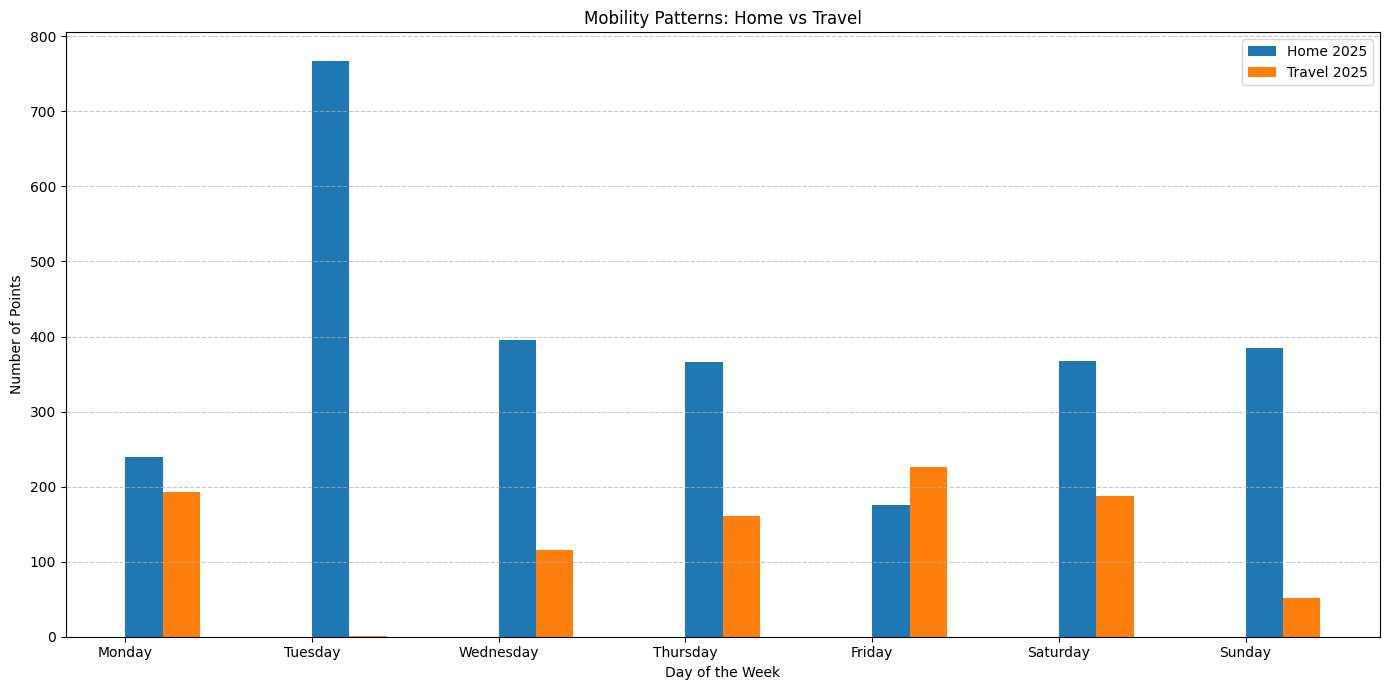

In [8]:
import matplotlib.pyplot as plt
import numpy as np


days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


# home_2024 = pivot_table[(2024.0, True)]
# travel_2024 = pivot_table[(2024.0, False)]
home_2025 = pivot_table[(2025.0, True)]
travel_2025 = pivot_table[(2025.0, False)]

x = np.arange(len(days_order))
width = 0.2


fig, ax = plt.subplots(figsize=(14, 7))


# rects1 = ax.bar(x - 1.5*width, home_2024.values, width, label='Home 2024')
# rects2 = ax.bar(x - 0.5*width, travel_2024.values, width, label='Travel 2024')
rects3 = ax.bar(x + 0.5*width, home_2025.values, width, label='Home 2025')
rects4 = ax.bar(x + 1.5*width, travel_2025.values, width, label='Travel 2025')

ax.set_xlabel('Day of the Week')
ax.set_ylabel('Number of Points')
ax.set_title('Mobility Patterns: Home vs Travel')
ax.set_xticks(x)
ax.set_xticklabels(days_order)
ax.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [9]:
df_filtered = df_filtered.sort_values('start_time').reset_index(drop=True)

df_filtered['time_diff_minutes_raw'] = df_filtered['start_time'].shift(-1) - df_filtered['start_time']
df_filtered['time_diff_minutes_raw'] = df_filtered['time_diff_minutes_raw'].dt.total_seconds() / 60
df_filtered['time_diff_minutes_raw'] = df_filtered['time_diff_minutes_raw'].fillna(0)


In [10]:
df_filtered['day_of_week'] = df_filtered['start_time'].dt.day_name()

time_summary = df_filtered.groupby(['year', 'day_of_week', 'at_home'])['time_diff_minutes_raw'].sum().reset_index()
pivot_time = time_summary.pivot_table(
    index='day_of_week',
    columns=['year', 'at_home'],
    values='time_diff_minutes_raw',
    fill_value=0
)
pivot_time = pivot_time.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

pivot_time


year         2025.0        
at_home       False   True 
day_of_week                
Monday       3272.0  4458.0
Tuesday         2.0  8644.0
Wednesday    1952.0  7194.0
Thursday     2684.0  6453.0
Friday       3706.0  3908.0
Saturday     1321.0  7372.0
Sunday        617.0  6890.0

In [11]:
# pivot_time['2024_total'] = pivot_time[(2024.0, True)] + pivot_time[(2024.0, False)]
pivot_time['2025_total'] = pivot_time[(2025.0, True)] + pivot_time[(2025.0, False)]

# pivot_time['2024_home_pct'] = (pivot_time[(2024.0, True)] / pivot_time['2024_total']) * 100
# pivot_time['2024_travel_pct'] = (pivot_time[(2024.0, False)] / pivot_time['2024_total']) * 100
pivot_time['2025_home_pct'] = (pivot_time[(2025.0, True)] / pivot_time['2025_total']) * 100
pivot_time['2025_travel_pct'] = (pivot_time[(2025.0, False)] / pivot_time['2025_total']) * 100

pivot_time[['2025_home_pct', '2025_travel_pct']]


year,2025_home_pct,2025_travel_pct
at_home,,
day_of_week,,
Monday,57.671410,42.328590
Tuesday,99.976868,0.023132
Wednesday,78.657337,21.342663
Thursday,70.624932,29.375068
Friday,51.326504,48.673496
Saturday,84.803865,15.196135
Sunday,91.781004,8.218996


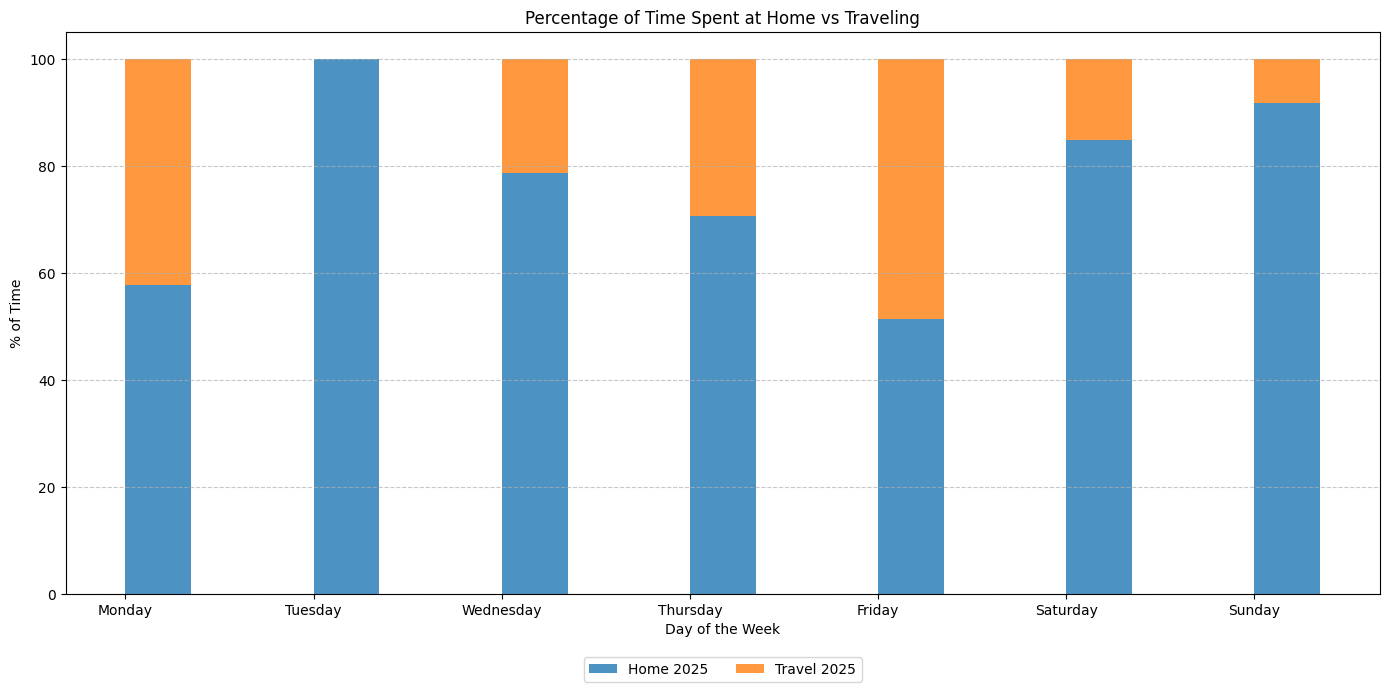

In [12]:
import matplotlib.pyplot as plt
import numpy as np

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x = np.arange(len(days_order))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))

# ax.bar(x - width/2, pivot_time['2024_home_pct'], width=width, label='Home 2024', alpha=0.8)
# ax.bar(x - width/2, pivot_time['2024_travel_pct'], width=width, bottom=pivot_time['2024_home_pct'], label='Travel 2024', alpha=0.8)

ax.bar(x + width/2, pivot_time['2025_home_pct'], width=width, label='Home 2025', alpha=0.8)
ax.bar(x + width/2, pivot_time['2025_travel_pct'], width=width, bottom=pivot_time['2025_home_pct'], label='Travel 2025', alpha=0.8)

ax.set_ylabel('% of Time')
ax.set_xlabel('Day of the Week')
ax.set_title('Percentage of Time Spent at Home vs Traveling')
ax.set_xticks(x)
ax.set_xticklabels(days_order)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [13]:
df_filtered['hour'] = df_filtered['start_time'].dt.hour

night_mask = (df_filtered['hour'] >= 20) | (df_filtered['hour'] <= 2)

df_night = df_filtered[night_mask].copy()

print(f"Night-time points: {len(df_night)} / {len(df_filtered)} total points")


Night-time points: 1471 / 3632 total points


In [14]:
df_night['day_of_week'] = df_night['start_time'].dt.day_name()

night_time_summary = df_night.groupby(['year', 'day_of_week', 'at_home'])['time_diff_minutes_raw'].sum().reset_index()
pivot_night_time = night_time_summary.pivot_table(
    index='day_of_week',
    columns=['year', 'at_home'],
    values='time_diff_minutes_raw',
    fill_value=0
)
pivot_night_time = pivot_night_time.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

pivot_night_time


year        2025.0        
at_home      False   True 
day_of_week               
Monday       418.0  2113.0
Tuesday        2.0  2532.0
Wednesday    263.0  3063.0
Thursday     295.0  3434.0
Friday       420.0  1478.0
Saturday     274.0  4116.0
Sunday        75.0  2204.0

In [15]:
# pivot_night_time['2024_total'] = pivot_night_time[(2024.0, True)] + pivot_night_time[(2024.0, False)]
pivot_night_time['2025_total'] = pivot_night_time[(2025.0, True)] + pivot_night_time[(2025.0, False)]

# pivot_night_time['2024_home_pct'] = (pivot_night_time[(2024.0, True)] / pivot_night_time['2024_total']) * 100
# pivot_night_time['2024_travel_pct'] = (pivot_night_time[(2024.0, False)] / pivot_night_time['2024_total']) * 100
pivot_night_time['2025_home_pct'] = (pivot_night_time[(2025.0, True)] / pivot_night_time['2025_total']) * 100
pivot_night_time['2025_travel_pct'] = (pivot_night_time[(2025.0, False)] / pivot_night_time['2025_total']) * 100

pivot_night_time[['2025_home_pct', '2025_travel_pct']]


year,2025_home_pct,2025_travel_pct
at_home,,
day_of_week,,
Monday,83.484789,16.515211
Tuesday,99.921073,0.078927
Wednesday,92.092604,7.907396
Thursday,92.089032,7.910968
Friday,77.871444,22.128556
Saturday,93.758542,6.241458
Sunday,96.709083,3.290917


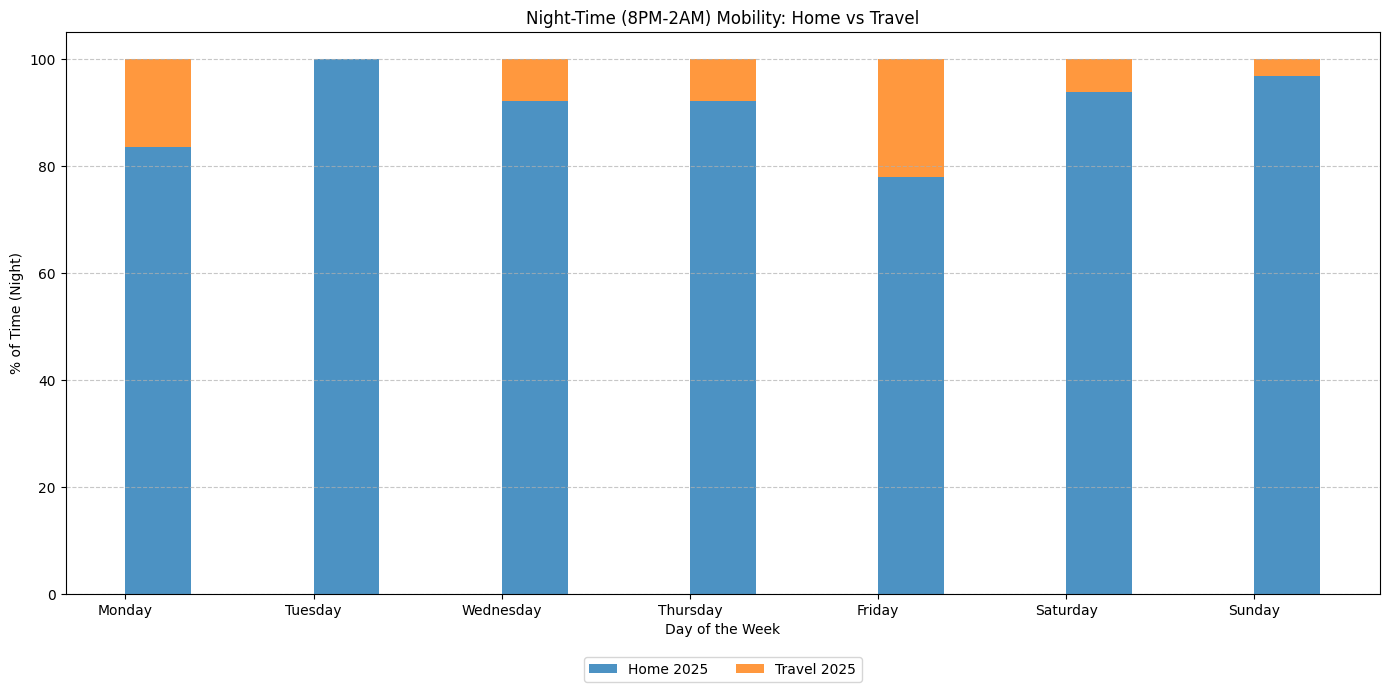

In [16]:
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(days_order))
width = 0.35
# ax.bar(x - width/2, pivot_night_time['2024_home_pct'], width=width, label='Home 2024', alpha=0.8)
# ax.bar(x - width/2, pivot_night_time['2024_travel_pct'], width=width, bottom=pivot_night_time['2024_home_pct'], alpha=0.8)

ax.bar(x + width/2, pivot_night_time['2025_home_pct'], width=width, label='Home 2025', alpha=0.8)
ax.bar(x + width/2, pivot_night_time['2025_travel_pct'], width=width, bottom=pivot_night_time['2025_home_pct'], alpha=0.8, label='Travel 2025')
ax.set_ylabel('% of Time (Night)')
ax.set_xlabel('Day of the Week')
ax.set_title('Night-Time (8PM-2AM) Mobility: Home vs Travel')
ax.set_xticks(x)
ax.set_xticklabels(days_order)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [18]:
# pivot_night_time['travel_delta_pct'] = pivot_night_time['2025_travel_pct'] - pivot_night_time['2024_travel_pct']
# pivot_night_time[['travel_delta_pct']]


In [19]:
# fig, ax = plt.subplots(figsize=(12, 6))

# x = np.arange(len(days_order))

# ax.bar(x, pivot_night_time['travel_delta_pct'], color='skyblue', edgecolor='black')
# ax.axhline(0, color='gray', linewidth=0.8)
# ax.set_ylabel('Change in Travel % (2025 vs 2024)')
# ax.set_xlabel('Day of the Week')
# ax.set_title('Change in Night-Time Travel % (8PM-2AM): 2025 vs 2024')
# ax.set_xticks(x)
# ax.set_xticklabels(days_order)

# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()


In [20]:
# biggest_changes = pivot_night_time['travel_delta_pct'].abs().sort_values(ascending=False)

# print("Days with biggest night-time travel changes:")
# print(biggest_changes)


In [21]:
df_filtered['year'] = df_filtered['start_time'].dt.year
night_mask = ((df_filtered['hour'] >= 20) | (df_filtered['hour'] <= 2)) & (df_filtered['year'] == 2025)
df_night_2025 = df_filtered[night_mask].copy()
df_night_2025['weekday'] = df_night_2025['start_time'].dt.day_name()

# home_categories = ["Home – Charlottesville", "Home – Millbury"]
df_night_2025['at_home'] = df_night_2025.apply(
    lambda row: is_home(row['latitude'], row['longitude'], home_locations),
    axis=1
)

# df_night_2025['at_home'] = df_night_2025['place_category'].isin(home_categories)

group_a = df_night_2025[df_night_2025['weekday'].isin(['Tuesday', 'Thursday'])]
group_b = df_night_2025[df_night_2025['weekday'].isin(['Monday', 'Wednesday'])]

def daily_home_pct(group):
    return (group.groupby(group['start_time'].dt.date)['at_home'].mean()) * 100

group_a_home_pct = daily_home_pct(group_a)
group_b_home_pct = daily_home_pct(group_b)

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(group_a_home_pct, group_b_home_pct, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("✅ Statistically significant difference: Night-time stay-at-home behavior differs between Tuesday+Thursday vs Monday+Wednesday!")
else:
    print("❌ No statistically significant difference detected.")


T-statistic: 1.9281
P-value: 0.0670
❌ No statistically significant difference detected.


In [22]:
import numpy as np

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    d = (np.mean(x) - np.mean(y)) / pooled_std
    return d

# Calculate
d_value = cohens_d(group_a_home_pct, group_b_home_pct)
print(f"Cohen's d: {d_value:.4f}")


Cohen's d: 0.7871


/tmp/ipykernel_239805/3766267679.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Monday+Wednesday', 'Tuesday+Thursday'], patch_artist=True)


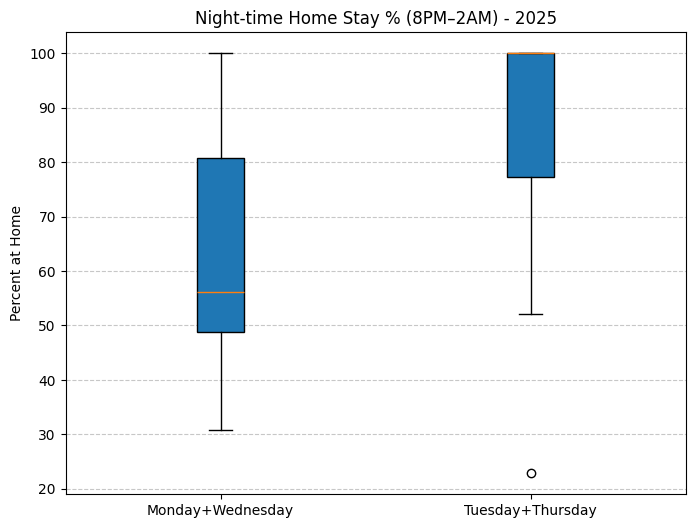

In [23]:

import matplotlib.pyplot as plt

data = [group_b_home_pct, group_a_home_pct]

plt.figure(figsize=(8,6))
plt.boxplot(data, labels=['Monday+Wednesday', 'Tuesday+Thursday'], patch_artist=True)

plt.title('Night-time Home Stay % (8PM–2AM) - 2025')
plt.ylabel('Percent at Home')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


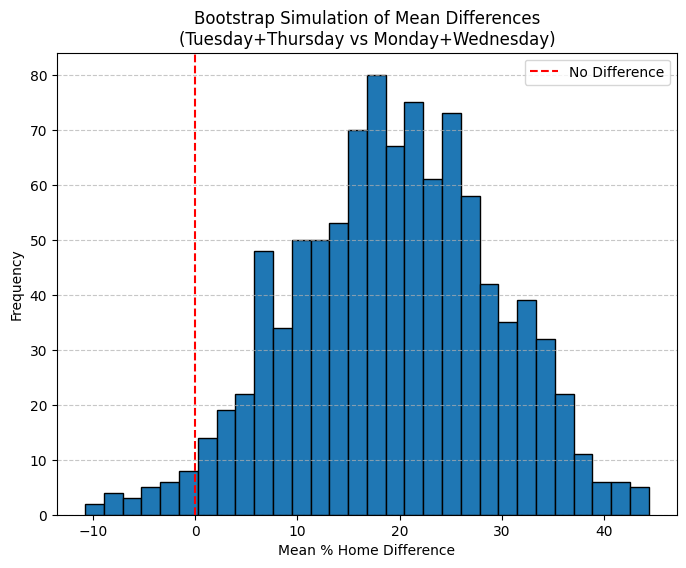

In [ ]:
np.random.seed(42)

bootstrap_diffs = []
n_iterations = 1000

for _ in range(n_iterations):
    sample_a = np.random.choice(group_a_home_pct, size=len(group_a_home_pct), replace=True)
    sample_b = np.random.choice(group_b_home_pct, size=len(group_b_home_pct), replace=True)
    diff = np.mean(sample_a) - np.mean(sample_b)
    bootstrap_diffs.append(diff)


plt.figure(figsize=(8,6))
plt.hist(bootstrap_diffs, bins=30, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='No Difference')
plt.title('Bootstrap Simulation of Mean Differences\n(Tuesday+Thursday vs Monday+Wednesday)')
plt.xlabel('Mean % Home Difference')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
